In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as TF
import torch.utils.data as data


import pandas as pd
import numpy as np
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Define transforms for dataset

transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
initial_dataset = ImageFolder(root='/home/iai/Desktop/bsh/active_learning/0406/dataset/mvtec2/initial', transform=transform)
train_dataset = ImageFolder(root='/home/iai/Desktop/bsh/active_learning/0406/dataset/mvtec2//train', transform=transform)
val_dataset = ImageFolder(root='/home/iai/Desktop/bsh/active_learning/0406/dataset/mvtec2/val', transform=transform)
test_dataset = ImageFolder(root='/home/iai/Desktop/bsh/active_learning/0406/dataset/mvtec2/test', transform=transform)

# Class mapping
class_map = {i: train_dataset.classes[i] for i in range(len(train_dataset.classes))}

initial_dataset.class_to_idx

cuda


/home/iai/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'anomaly': 0, 'good': 1}

In [2]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))
print(len(initial_dataset))


3111
1070
1070
100


In [3]:
# Define ResNet model
class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=True)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        x = self.resnet18.layer1(x)
        x = self.resnet18.layer2(x)
        x = self.resnet18.layer3(x)
        x = self.resnet18.layer4(x)

        x = self.resnet18.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def train(model, optimizer, criterion, labeled_loader):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    total = 0
    for images, labels in labeled_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_acc += (predicted == labels).sum().item()
    train_loss /= len(labeled_loader)
    train_acc /= total
    return train_loss, train_acc

In [4]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=4, verbose=False, delta=0, path='checkpoint.pt', min_epoch = 0, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.epoch = 0
        self.min_epoch = min_epoch
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss
        self.epoch +=1
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            
            if self.epoch < self.min_epoch:
                self.counter = 0
                self.trace_func("Not enough epoch")
            else:
                self.counter += 1
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint_unc_cutpaste.pt')
        self.val_loss_min = val_loss

In [5]:
# CutPaste

import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF

def apply_cutpaste(image):
    """
    Applies Cut-and-Paste data augmentation to an input image.

    Args:
    - image (torch.Tensor): input image tensor of shape (C, H, W).

    Returns:
    - augmented_image (Image.Image): cut-and-paste augmented image.
    """
    # Convert image to numpy array
    image_np = image.permute(1, 2, 0).numpy()

    # Generate random patch size : considering ratio
    min_size = int(min(image_np.shape[:2]) * 0.02)
    max_size = int(min(image_np.shape[:2]) * 0.15)
    patch_width = np.random.randint(min_size, max_size+1)
    patch_height = np.random.choice([np.random.uniform(0.3, 1), np.random.uniform(1, 3.3)]) * patch_width
    patch_size = (int(patch_width), int(patch_height))

    # Generate random patch position
    center_x, center_y = np.random.randint(patch_size[0], image_np.shape[0] - patch_size[0]), np.random.randint(patch_size[1], image_np.shape[1] - patch_size[1])

    # Generate random crop positions for image
    crop_x_min, crop_x_max = center_x - patch_size[0], center_x + patch_size[0]
    crop_y_min, crop_y_max = center_y - patch_size[1], center_y + patch_size[1]

    # Crop image
    image_crop = image_np[crop_x_min:crop_x_max, crop_y_min:crop_y_max]

    # Generate random paste position
    paste_x, paste_y = np.random.randint(patch_size[0], image_np.shape[0] - patch_size[0]), np.random.randint(patch_size[1], image_np.shape[1] - patch_size[1])

    # Paste cropped image onto image
    image_paste = image_np.copy()
    image_paste[paste_x-patch_size[0]:paste_x+patch_size[0], paste_y-patch_size[1]:paste_y+patch_size[1]] = image_crop

    # Convert image back to torch tensor
    augmented_image = TF.to_tensor(image_paste).permute(1, 2, 0)
    augmented_image = (augmented_image.numpy() * 255).astype(np.uint8)
    augmented_image = Image.fromarray(augmented_image)

    return augmented_image


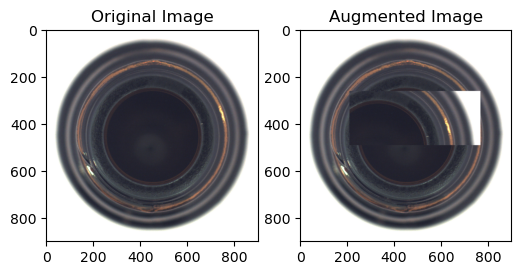

In [6]:
#Cutpaset 확인 _ 논문 방식
import torch
import numpy as np
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt

# Load example image
image_path = '/home/iai/Desktop/bsh/active_learning/0406/dataset/mvtec2/train/good/bottle_good (20).png'
image = Image.open(image_path)

# Convert image to tensor
image_tensor = TF.to_tensor(image)

# Apply cut-and-paste data augmentation
augmented_image = apply_cutpaste(image_tensor)

# Plot original and augmented images side by side
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[1].imshow(augmented_image)
ax[1].set_title('Augmented Image')
plt.show()

In [7]:
print(len(train_dataset))

3111


In [8]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import warnings
import pandas as pd
import os
from shutil import copyfile
warnings.filterwarnings('ignore')

test_loss_unc = []
test_acc_unc = []
test_auc_score_unc = []
test_roc_auc_unc = []
test_precision_unc = []
test_recall_unc = []
test_f1_unc = []

# df_unc2_test = pd.DataFrame(columns = train_dataset.classes)
df_unc2_cutpaste = pd.DataFrame(columns = ['anomaly', 'good'])


batch_size = 128

# Define initial labeled dataset
labeled_indices_unc = torch.arange(len(initial_dataset))
labeled_dataset_unc = torch.utils.data.Subset(initial_dataset, labeled_indices_unc)

unlabeled_indices_unc = torch.arange(len(train_dataset))
unlabeled_dataset_unc = torch.utils.data.Subset(train_dataset, unlabeled_indices_unc)

tmp_indices_unc = torch.tensor([], dtype=torch.int64)

# Define data loaders
labeled_loader_unc = DataLoader(labeled_dataset_unc, batch_size=128, shuffle=True)
unlabeled_loader_unc = DataLoader(unlabeled_dataset_unc, batch_size=128, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [9]:
def count_good_and_anomaly_classes(dataset):
    """
    Returns the count of instances for classes that contain "good" or "anomaly" in the class name.

    Args:
    - dataset (list): labeled dataset where each element is a tuple (image, label).

    Returns:
    - dict: a dictionary containing the count of each "good" or "anomaly" class in the dataset, where the keys are 
            "good" or "anomaly" and the values are the count of each class.
    """
    # Create dictionary with counts of each class containing "good" or "anomaly"
    counts = {'good': 0, 'anomaly': 0}
    for _, label in dataset:
        class_name = list(initial_dataset.class_to_idx.keys())[list(initial_dataset.class_to_idx.values()).index(label)]
        # Check if class_name contains "good" or "anomaly" keyword
        if "good" in class_name:
            counts['good'] += 1
        elif "anomaly" in class_name:
            counts['anomaly'] += 1

    return counts


In [10]:
print(count_good_and_anomaly_classes(labeled_dataset_unc)['good'])
print(count_good_and_anomaly_classes(labeled_dataset_unc)['anomaly'])

77
23


Step number: 1
Num of normal class :  77
Num of anomaly class :  23
Num of normal class :  77
Num of anomaly class :  100
Num of total dataset after cutpaste :  177
Step : 1, Epoch : 1 - Train Loss: 0.5485, Train Accuracy: 0.6780
Validation loss decreased (inf --> 0.637144).  Saving model ...
Val Loss: 0.6371, Val Accuracy: 0.6280
AUC Score: 0.4973

Step : 1, Epoch : 2 - Train Loss: 0.2093, Train Accuracy: 0.9379
EarlyStopping counter: 1 out of 20
Val Loss: 0.6515, Val Accuracy: 0.6729
AUC Score: 0.5155

Step : 1, Epoch : 3 - Train Loss: 0.1997, Train Accuracy: 0.9605
Validation loss decreased (0.637144 --> 0.632383).  Saving model ...
Val Loss: 0.6324, Val Accuracy: 0.6953
AUC Score: 0.5136

Step : 1, Epoch : 4 - Train Loss: 0.0935, Train Accuracy: 0.9605
EarlyStopping counter: 1 out of 20
Val Loss: 0.7535, Val Accuracy: 0.6981
AUC Score: 0.5224

Step : 1, Epoch : 5 - Train Loss: 0.1187, Train Accuracy: 0.9379
EarlyStopping counter: 2 out of 20
Val Loss: 0.7385, Val Accuracy: 0.7009
A

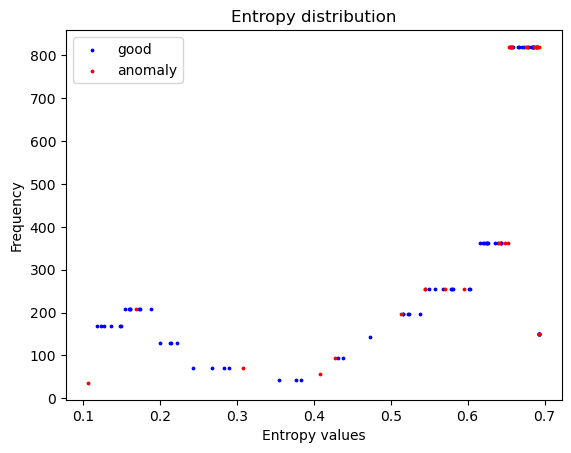

{'anomaly': 0, 'good': 1}
Step number: 2
Num of normal class :  78
Num of anomaly class :  23
Num of normal class :  78
Num of anomaly class :  101
Num of total dataset after cutpaste :  179
Step : 2, Epoch : 1 - Train Loss: 0.3986, Train Accuracy: 0.5922
Validation loss decreased (inf --> 0.699746).  Saving model ...
Val Loss: 0.6997, Val Accuracy: 0.4888
AUC Score: 0.5693

Step : 2, Epoch : 2 - Train Loss: 0.1807, Train Accuracy: 0.8994
Validation loss decreased (0.699746 --> 0.686000).  Saving model ...
Val Loss: 0.6860, Val Accuracy: 0.6131
AUC Score: 0.5525

Step : 2, Epoch : 3 - Train Loss: 0.0815, Train Accuracy: 0.9218
EarlyStopping counter: 1 out of 20
Val Loss: 0.6926, Val Accuracy: 0.6112
AUC Score: 0.5429

Step : 2, Epoch : 4 - Train Loss: 0.0887, Train Accuracy: 0.9218
Validation loss decreased (0.686000 --> 0.678603).  Saving model ...
Val Loss: 0.6786, Val Accuracy: 0.6121
AUC Score: 0.5449

Step : 2, Epoch : 5 - Train Loss: 0.0482, Train Accuracy: 0.9050
EarlyStopping c

In [11]:
step = 1

anomaly_count = 0
normal_count = 0
num_normal = 0
num_anomaly = 0
tmp_ano=0
tmp_ano=0


# Active learning loop
while(len(unlabeled_dataset_unc) > 0):
    print("Step number:", step)

    labeled_dataset_unc_copy = torch.utils.data.Subset(labeled_dataset_unc, list(range(len(labeled_dataset_unc))))
    labeled_loader_unc_copy = DataLoader(labeled_dataset_unc, batch_size=128, shuffle=True)

    num_normal = count_good_and_anomaly_classes(labeled_dataset_unc_copy)['good']
    num_anomaly = count_good_and_anomaly_classes(labeled_dataset_unc_copy)['anomaly']

    print("Num of normal class : ", num_normal)
    print("Num of anomaly class : ", num_anomaly)

    # Calculate the number of additional good samples required
    num_additional_normal_samples = num_normal

    # Select random good samples to perform cutpaste augmentation
    good_indices = [(i,label) for i, (_, label) in enumerate(labeled_dataset_unc_copy) if label == 1]
    good_indices_first = [i[0] for i in good_indices]
    good_indices_second = [i[1] for i in good_indices]

    cutpaste_indices = np.random.choice(good_indices_first, size=num_additional_normal_samples, replace=True)

    labeled_dataset_unc_copy = list(labeled_dataset_unc_copy)

    for i in cutpaste_indices:
        image = labeled_dataset_unc_copy[i][0]
        cutpaste_image = apply_cutpaste(image)
        to_tensor = ToTensor()
        cutpaste_image = to_tensor(cutpaste_image)
        tmp = good_indices_first.index(i)
        labeled_dataset_unc_copy.append((cutpaste_image, 0))
    
    labeled_loader_unc_copy = DataLoader(labeled_dataset_unc_copy, batch_size=128, shuffle=True)

    print("Num of normal class : ", count_good_and_anomaly_classes(labeled_dataset_unc_copy)['good'])
    print("Num of anomaly class : ", count_good_and_anomaly_classes(labeled_dataset_unc_copy)['anomaly'])
    print("Num of total dataset after cutpaste : ", len(labeled_dataset_unc_copy))

    #model

    model_unc = ResNet18(num_classes=2).to(device)
    early_stopping_unc = EarlyStopping(patience = 20, verbose = True, min_epoch = 0)
    weights = [0.95, 0.05]
    weights = torch.FloatTensor(weights).to(device)
    criterion = nn.CrossEntropyLoss(weights).to(device)
    optimizer = torch.optim.Adam(model_unc.parameters(), lr=0.0001)

    for epoch in range(200):
        # Train model on labeled dataset
        train_loss, train_acc = train(model_unc, optimizer, criterion, labeled_loader_unc_copy)
        print(f"Step : {step}, Epoch : {epoch+1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")    

    # Evaluate model on val dataset
        model_unc.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_acc = 0.0
            total = 0
            y_true = []
            y_pred = []
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model_unc(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                val_acc += (predicted == labels).sum().item()
                y_true.extend(labels.tolist())
                y_pred.extend(predicted.tolist())
            val_loss /= len(val_loader)
            val_acc /= total

            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average = 'binary')
            # Compute AUC score and ROC curve
            fpr, tpr, thresholds = roc_curve(y_true, y_pred)
            auc_score = roc_auc_score(y_true, y_pred)
            roc_auc = auc(fpr, tpr)
            
            # Early Stopping Condition
            early_stopping_unc(val_loss, model_unc)
            
            if early_stopping_unc.early_stop:
                print("Early stopping")
                print(f"Val Precision: {precision.item():.4f}, Val Recall: {recall.item():.4f}, Val F1 Score: {f1.item():.4f}")
                break
            
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")            
            print(f"AUC Score: {auc_score:.4f}")
            print("")
            
        model_unc.load_state_dict(torch.load('checkpoint_unc_cutpaste.pt'))

    
    # Evaluate model on Test Dataset
    model_unc.load_state_dict(torch.load('checkpoint_unc_cutpaste.pt'))
    model_unc.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        total = 0
        y_true = []
        y_pred = []
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_unc(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            test_acc += (predicted == labels).sum().item()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
        test_loss /= len(test_loader)
        test_acc /= total
        
        # Compute AUC score and ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc_score_unc = roc_auc_score(y_true, y_pred)
        roc_auc_unc = auc(fpr, tpr)

        precision_unc, recall_unc, f1_unc, _ = precision_recall_fscore_support(y_true, y_pred, average = 'binary')
        test_loss_unc.append(test_loss)
        test_acc_unc.append(test_acc)
        test_auc_score_unc.append(auc_score_unc)
        test_roc_auc_unc.append(roc_auc_unc)
        test_precision_unc.append(precision_unc)
        test_recall_unc.append(recall_unc)
        test_f1_unc.append(f1_unc)

        
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
        print(f"AUC Score: {auc_score_unc:.4f}")
    

    # Iteration end condition
    if len(labeled_dataset_unc) > int(len(train_dataset)/2):
        break
    
    # Make model predictions on unlabeled dataset
    model_unc.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in unlabeled_loader_unc:
            images = images.to(device)
            output = model_unc(images)
            predictions.append(output)
    predictions = torch.cat(predictions, dim=0)

    # Select samples to label using entropy-based method
    entropy = -torch.sum(torch.softmax(predictions, dim=1) * torch.log(torch.softmax(predictions, dim=1)), dim=1)
    _, idx = torch.topk(entropy, k = 20) # select top 20


    # Create a subset dataset
    subset1 = data.Subset(initial_dataset, range(len(initial_dataset)))
    tmp_indices_unc = torch.cat([tmp_indices_unc, unlabeled_indices_unc[idx]])
    subset2 = data.Subset(train_dataset, tmp_indices_unc)
    # Concatenate the two subset datasets
    labeled_dataset_unc = data.ConcatDataset([subset1, subset2])

    unlabeled_indices_unc = unlabeled_indices_unc[~torch.eq(unlabeled_indices_unc.unsqueeze(1), unlabeled_indices_unc[idx]).any(1)]
    unlabeled_dataset_unc = torch.utils.data.Subset(train_dataset, unlabeled_indices_unc)
    print("Updated Length of labeled dataset : ",len(labeled_dataset_unc))
    print("Length of unlabeled dataset : ",len(unlabeled_dataset_unc))
    print(count_good_and_anomaly_classes(labeled_dataset_unc)['good'])
    print(count_good_and_anomaly_classes(labeled_dataset_unc)['anomaly'])
    print("-----------------------------------------------------------")

    # Update labeled and unlabeled data loaders
    labeled_loader_unc = DataLoader(labeled_dataset_unc, batch_size=batch_size, shuffle=True)
    unlabeled_loader_unc = DataLoader(unlabeled_dataset_unc, batch_size=batch_size, shuffle=True)   #이거로 entropy

    anomaly_count = count_good_and_anomaly_classes(labeled_dataset_unc)['anomaly'] - num_anomaly
    normal_count = count_good_and_anomaly_classes(labeled_dataset_unc)['good'] - num_normal

    new_row = {'anomaly': anomaly_count, 'good': normal_count}

    # Move tensor to CPU before converting to numpy array
    entropy = entropy.cpu().detach().numpy()

    # Get the labels of the samples
    labels = []
    for images, lbls in labeled_loader_unc:
        labels.extend(lbls.numpy())

    # Get the distribution of entropy values
    entropy_hist, bin_edges = np.histogram(entropy, bins='auto',range=(0, 1))

    # Plot the histogram of entropy values
    import matplotlib.pyplot as plt

    good_indices = [i for i, label in enumerate(labels) if label == 1]                # good label == 1
    anomaly_indices = [i for i, label in enumerate(labels) if label == 0]             # anomaly label == 0
    plt.scatter([entropy[i] for i in good_indices], [entropy_hist[int(np.digitize(entropy[i], bin_edges))-1] for i in good_indices], s=3,c='blue', label='good')
    plt.scatter([entropy[i] for i in anomaly_indices], [entropy_hist[int(np.digitize(entropy[i], bin_edges))-1] for i in anomaly_indices], s=3,c='red', label='anomaly')
    
    plt.title("Entropy distribution")
    plt.xlabel("Entropy values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Add text to the plot
    # plt.text(0.8, 0.9, f"Step : {step}", transform=plt.gca().transAxes, ha='right')
    # plt.text(0.8, 0.8, f"Number of samples: {new_row}", transform=plt.gca().transAxes, ha='right')
    # plt.text(0.8, 0.7, f"Number of normal: {count_good_and_anomaly_classes(labeled_dataset_unc)['good']}", transform=plt.gca().transAxes, ha='right')
    # plt.text(0.8, 0.6, f"Number of anomaly: {count_good_and_anomaly_classes(labeled_dataset_unc)['anomaly']}", transform=plt.gca().transAxes, ha='right')
    # plt.show()

    df_unc2_cutpaste = pd.concat([df_unc2_cutpaste, pd.DataFrame([new_row])], ignore_index=True)
    print(new_row)

    step+=1

In [ ]:
print(labeled_dataset_unc)
print(type(initial_dataset))
print(entropy)

<class 'torchvision.datasets.folder.ImageFolder'>
[0.64393955 0.6844883  0.6504346  ... 0.69185776 0.6891215  0.5550766 ]


In [ ]:
print(test_loss_unc)
print(test_acc_unc)
print(test_auc_score_unc)
print(test_roc_auc_unc)
print(test_precision_unc)
print(test_recall_unc)
print(test_f1_unc)

[0.45757967233657837, 0.6803456374577114, 0.8307946707521167, 0.7700336234910148, 0.8073542203222003]
[0.9396751740139211, 0.6009280742459396, 0.43039443155452434, 0.41299303944315546, 0.3654292343387471]
[0.5275577136042253, 0.4594655990004827, 0.5349831047505467, 0.536843001959281, 0.48977766419626884]
[0.5275577136042253, 0.4594655990004827, 0.5349831047505467, 0.536843001959281, 0.48977766419626884]
[0.9527744982290437, 0.9439252336448598, 0.9581005586592178, 0.9589442815249267, 0.9473684210526315]
[0.9853479853479854, 0.6166056166056166, 0.4188034188034188, 0.3992673992673993, 0.3516483516483517]
[0.9687875150060025, 0.7459379615952733, 0.5828377230246389, 0.5637931034482759, 0.5129118432769368]


In [ ]:
df_unc2_cutpaste

,anomaly,good
0,0,1
1,0,1
2,1,0
3,0,1


In [ ]:
df_unc2_cutpaste.to_csv('/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/feedback/2classes/good_initial/df_unc2_cutpaste.csv')